In [1]:
# -*- coding: utf-8 -*-
#  Original file by the CIL team:
# https://github.com/TomographicImaging/CIL-Demos/blob/main/demos/2_Iterative/05_Laminography_with_TV.ipynb   

In [2]:
import cil
print(f"Using CIL version {cil.__version__}")

Using CIL version 24.2.0


In [4]:
from cil.framework import AcquisitionGeometry

from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import ZeroFunction, LeastSquares

from cil.io import TIFFStackReader

from cil.processors import TransmissionAbsorptionConverter, Binner, Normaliser

# from cil.plugins.tigre import ProjectionOperator
from cil.plugins.astra import ProjectionOperator
from cil.recon import FDK

from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

import numpy as np
import os

from util.pcaReader import read_pca_file

# Adapted from: "Laminography reconstruction with TV regularisation using FISTA"

In [6]:
# Set the path to the directory containing the data
path = "../keyboard-data/keyboard_4/"
filename = "keyboard_4"

In [7]:
filepath = path + filename + '.pca'
params = read_pca_file(filepath)
for k in params.keys():
    print(f"{k}: {params[k]}")

72 lines, found 53 values (discarded 25)
Version-pca: 2

FDD: 650.1999701125958
FOD: 93.5226587597524
cx: 517.0070660992587
cy: 490.5149799815266
CalibValue: -33.65098318912923
DetectorRot: -0.08553882529839198
Tilt: 44.9741793137597
Oblique: 45.0
NumberImages: 758
StartImg: 1
RotationSector: 360.0
PlanarCTRotCenter: 0.0
ROILowerHeight: -74.0
ROIUpperHeight: 74.0
ROIWidthX: 707.0
ROIWidthY: 707.0
ROIOffsetX: 0.0
ROIOffsetY: 0.0
DimX: 1000.0
DimY: 1000.0
FreeRay: 1992
PixelsizeX: 0.2
PixelsizeY: 0.2
Voltage: 100.0
Current: 80.0
CenterX: 245.31154921
CenterY: 180.43867718


## Create the acquisition geometry

We know the system parameters from the paper and author clarification. We use this to set up a 3D cone-beam geometry with the rotation axis tilited 30 degrees towards the source.


In [8]:
# Acquisition geometry parameters
SOD = params["FOD"] # Source-Origin-distance
print(f'SOD: {SOD:.3f} mm')
SDD = params["FDD"] # Source-Detector-distance
print(f'SDD: {SDD:.3f} mm')
ODD = SDD - SOD # Origin-detector-distance
print(f'ODD: {ODD:.3f} mm')
pixelSize = params["PixelsizeX"] # Raw detector pixel size
print(f'Detector pixel size: {pixelSize:.3f} mm')

num_pixels = (params["DimX"], params["DimY"]) # Projection image width and height

num_images = params["NumberImages"]

SOD: 93.523 mm
SDD: 650.200 mm
ODD: 556.677 mm
Detector pixel size: 0.200 mm


In [9]:
tilt = params["Tilt"] * np.pi / 180. # Using radians

angles_list = np.linspace(0, params["RotationSector"], params["NumberImages"], endpoint=False)

rotation_axis = -np.array([0,-np.sin(tilt), np.cos(tilt)]) # Points down for correct rotation direction
height_offset = params["PlanarCTRotCenter"] * np.array([0,-np.sin(tilt), np.cos(tilt)]) # Offset along the rotation axis direction (because the machine assumes rotating table remains level and detector rotates)

We create the CIL Cone3D `AcquisitionGeometry`, `ag`, and print it for information and also display it:

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -650.19997011,    0.        ]
	Rotation axis position: [ 0., -0.,  0.]
	Rotation axis direction: [-0.        ,  0.70678805, -0.70742537]
	Detector position: [  0.        , 556.67731135,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.2 0.2]
	Pixel origin: top-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 758
	Angles 0-9 in degrees: [0.        , 0.47493404, 0.9498681 , 1.4248021 , 1.8997362 , 2.3746703 ,
 2.8496041 , 3.3245382 , 3.7994723 , 4.2744064 ]
	Angles 748-757 in degrees: [355.25067, 355.7256 , 356.20053, 356.67548, 357.1504 , 357.62534,
 358.10025, 358.5752 , 359.05014, 359.52505]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


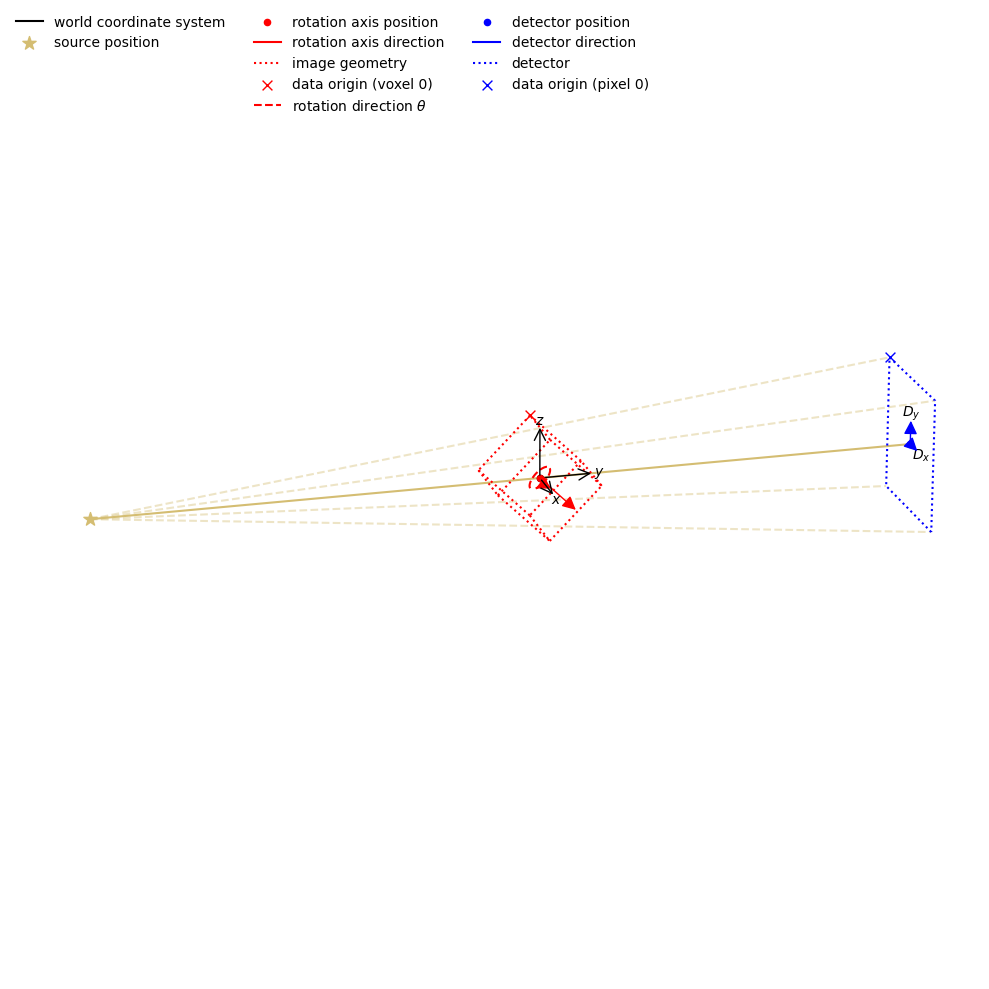

In [11]:
ag = AcquisitionGeometry.create_Cone3D( source_position=[0.0, -SDD,0.0], 
                                        detector_position=[0.0, ODD, 0.0],
                                        rotation_axis_position=height_offset,
                                        rotation_axis_direction= rotation_axis) \
                        .set_angles(angles=angles_list, angle_unit='degree') \
                        .set_panel( num_pixels=num_pixels, 
                                    pixel_size=pixelSize,
                                    origin='top-left') \
                        .set_labels(['angle','vertical','horizontal'])
print(ag)
show_geometry(ag, figsize=(10,16), view_distance=1, azimuthal=-15)

# Read in the data
We will start by reading in data from a stack of tiffs. As we read in the data we will symmetrically crop and down-sample the data. We will remove a 100 pixel border from each projection, and we will only read in every 7th projection. This significantly reduces the computational time and memory cost without a loss of reconstruction quality.

To specify the part of the full data to read in, the `TIFFStackReader` uses the default labels 'axis_0', 'axis_1' and 'axis_2' to refer to the dimensions of the TIFF stack, being files, vertical and horizontal pixels, respectively.

We want to crop in the horizontal and vertical directions, and slice the angles direction. We create a region of interest (RoI) dictionary `roi` with the axis name, and a tuple containing the starting pixel index, the end pixel index and the step size to slice.

We also need to update the geometry to account for the new panel size.


In [12]:
crop = 0
ang_skip = 2

if crop == 0:
       roi = {'axis_0': (None, -1, ang_skip),
              'axis_1': (None, None, None), 
              'axis_2': (None, None, None)}
else:
       roi = {'axis_0': (None, None, ang_skip),
       'axis_1': (crop, -crop, None), 
       'axis_2': (crop, -crop, None)}

num_pixels_x = (num_pixels[0] - 2*crop)
num_pixels_y = (num_pixels[1] - 2*crop)

angles_list = np.linspace(0, params["RotationSector"], int(params["NumberImages"] / ang_skip), endpoint=False)

ag.set_angles(angles_list)
ag.set_panel(num_pixels=[num_pixels_x,num_pixels_y],pixel_size=pixelSize,origin='top-left')
       

From `cil.io` we import and create a `TIFFStackReader` instance to read in the data, this is created with the directory path and the RoI dictionary defined above.

As we have already defined our acquisition geometry we can use the function `read_as_AcquisitionData()` to pass this to the reader. The reader will use this to configure and return an `AcquisitionData` object containing the data and the geometry describing it.

In [13]:
reader = TIFFStackReader(file_name=path, roi=roi, mode='slice')
acq_data = reader.read_as_AcquisitionData(ag)

islicer(acq_data, direction='angle', origin='upper-left')


Finally we convert the intensity data to attenuation data using the Beer-Lambert law

In [14]:
max_k = params["FreeRay"]
print(f"{max_k = }, about {100*max_k / 2**14:.3f} % of the maximum (of 14 bit int)")
converter = TransmissionAbsorptionConverter(white_level=max_k)
acq_data_atten = converter(acq_data)

islicer(acq_data_atten, direction='angle',origin='upper-left')

max_k = 1992, about 12.158 % of the maximum (of 14 bit int)


In [15]:
del acq_data

We will run this notebook over 4x binned data for speed. The iterative reconstructions will take approximately 5 minutes at this binning.

We use CIL's Binner processor to average together every 4 pixels in the horizontal and vertical directions.

We define the RoI using the same syntax as previously, however now we set our start and stop indices to `None` as we want to include the full width of the data.

In [16]:
#bin the data for speed 
binning = 2

roi = {'horizontal': (None, None, binning),
       'vertical': (None, None, binning)}
acq_data = Binner(roi=roi)(acq_data_atten)

#note the number of pixels and pixel size is updated for you
print(ag)

islicer(acq_data, direction='angle', origin='upper-left')

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -650.19997011,    0.        ]
	Rotation axis position: [ 0., -0.,  0.]
	Rotation axis direction: [-0.        ,  0.70678805, -0.70742537]
	Detector position: [  0.        , 556.67731135,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.2 0.2]
	Pixel origin: top-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 379
	Angles 0-9 in degrees: [0.       , 0.9498681, 1.8997362, 2.8496041, 3.7994723, 4.7493405,
 5.6992083, 6.6490765, 7.5989447, 8.548813 ]
	Angles 369-378 in degrees: [350.5013 , 351.4512 , 352.40106, 353.35092, 354.30078, 355.25067,
 356.20053, 357.1504 , 358.10025, 359.05014]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


In [17]:
del acq_data_atten

In [18]:
acq_data.reorder('astra')
ag = acq_data.geometry

Number of channels: 1
channel_spacing: 1.0
voxel_num : x707,y707,z100
voxel_size : x0.21549828805231855,y0.21549828805231855,z0.21549828805231855
center : x0,y0,z0



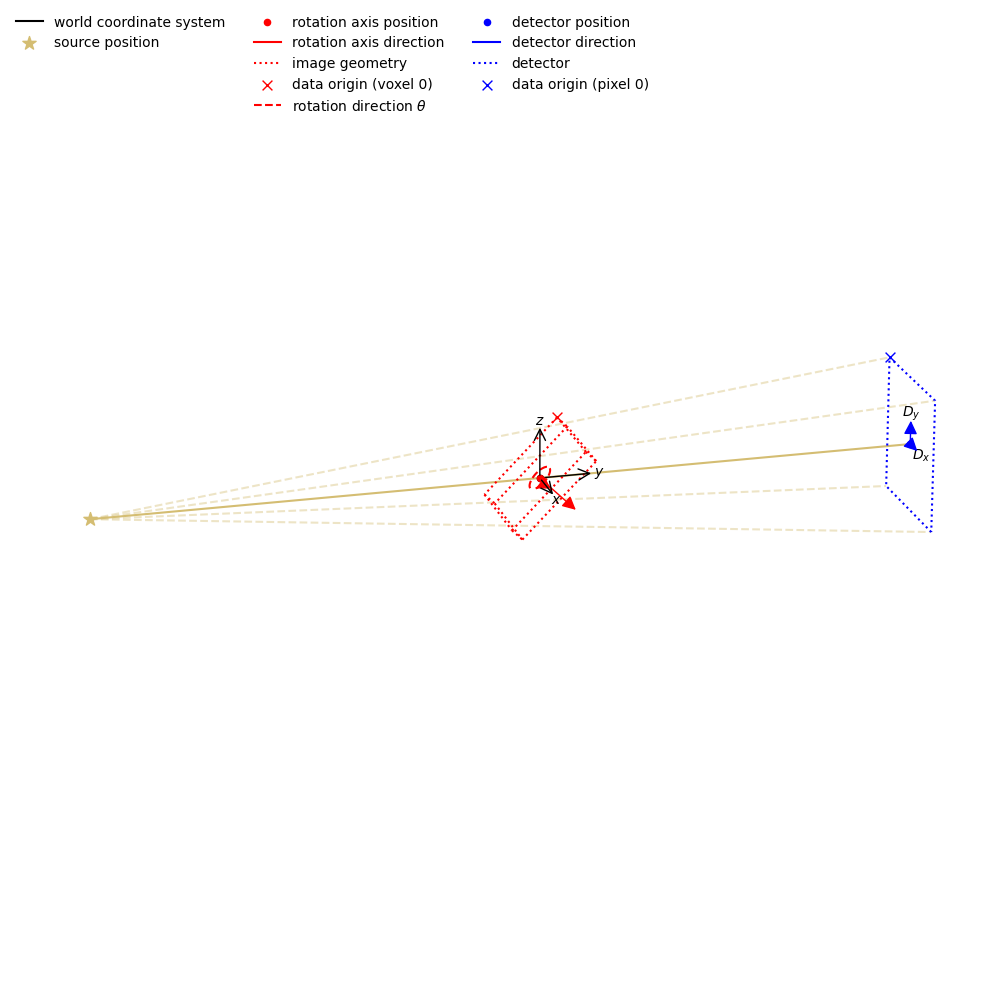

In [20]:
ig = ag.get_ImageGeometry()
ig.voxel_num_z = 100 # Magic number

# Compute the maximal size of object in view of some projection (i.e. when the object is slanted away from the X-ray source)
xy_slanted = int(ig.voxel_num_x / np.sin(tilt))
ig.voxel_num_x = xy_slanted
ig.voxel_num_y = xy_slanted
print(ig)

show_geometry(ag, ig, azimuthal=-15)

## Reconstructing the data using unregularised Least Squares with FISTA

Using our `ImageGeometry`, `ig`, and `AcquisitionGeometry`, `ag`, we define our projector and a data-fidelity `LeastSquares` term.

We can use FISTA to iteratively solve this reconstruction.


In [21]:
A = ProjectionOperator(ig, ag, 'gpu')
LS = LeastSquares(A=A, b=acq_data)
fista_LS = FISTA(initial=ig.allocate(0), f=LS, g=ZeroFunction(), update_objective_interval=1)


## Start with a simple backprojection

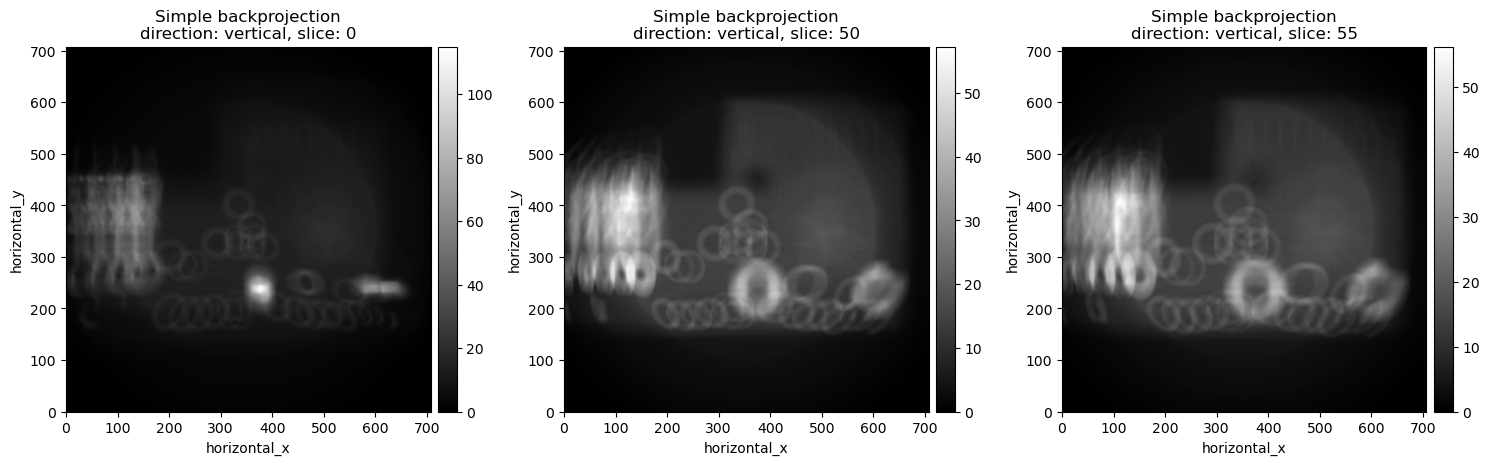

In [22]:
bp = A.adjoint(acq_data)

slice_list = [0, 50, 55]
show2D(bp,slice_list=slice_list, title="Simple backprojection", fix_range=(0,None), num_cols=3)

In [23]:
fista_LS.run(10)
LS_reco = fista_LS.solution

  0%|          | 0/10 [00:00<?, ?it/s]

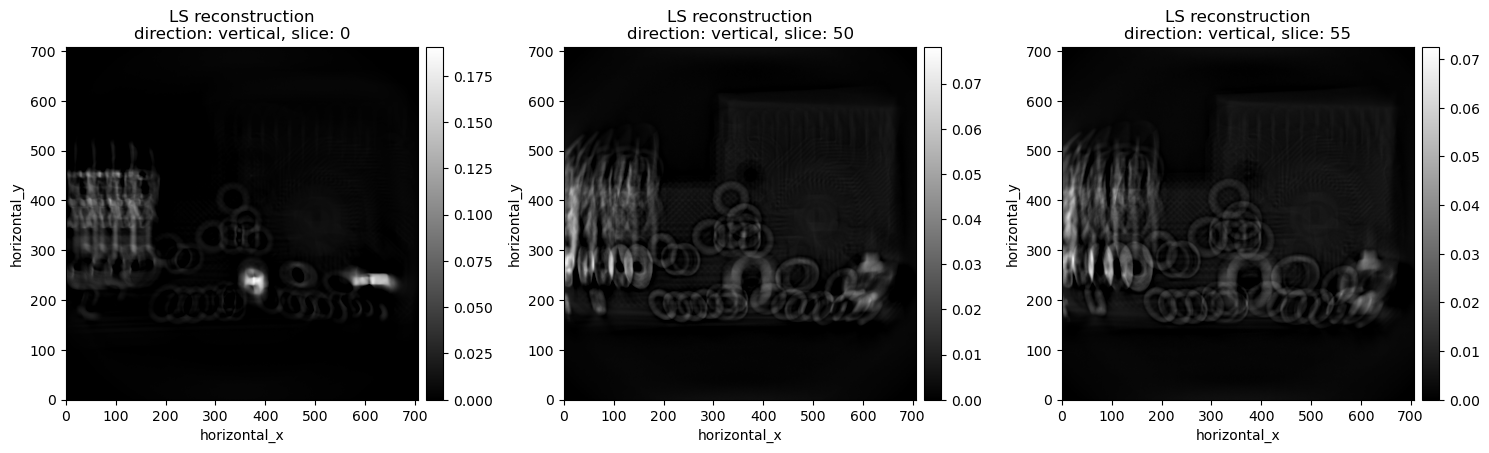

In [24]:
show2D(LS_reco,slice_list=slice_list, title="LS reconstruction", fix_range=(0,None), num_cols=3)

In [ ]:
islicer(LS_reco, direction="vertical", minmax=(0,0.1))

## Reconstructing the data using Total Variation regularised Least Squares with FISTA

We reuse the `LeastSquares` function, but now we also can define a `TotalVariation` function. In this example we use `FGP_TV` from the CCPi-RegularisationToolkit CIL plugin with the `gpu` backend.

We also can add a non-negativity constraint to the function.

Again, we set up and use FISTA to iteratively solve this reconstruction.

For some reason this is very slow.

In [28]:
alpha = 0.1
TV = FGP_TV(alpha=alpha, nonnegativity=True, device="gpu")
fista_TV = FISTA(initial=ig.allocate(0), f=LS, g=TV, update_objective_interval=10)

In [29]:
fista_TV.run(10)
TV_reco = fista_TV.solution


  0%|          | 0/10 [00:00<?, ?it/s]

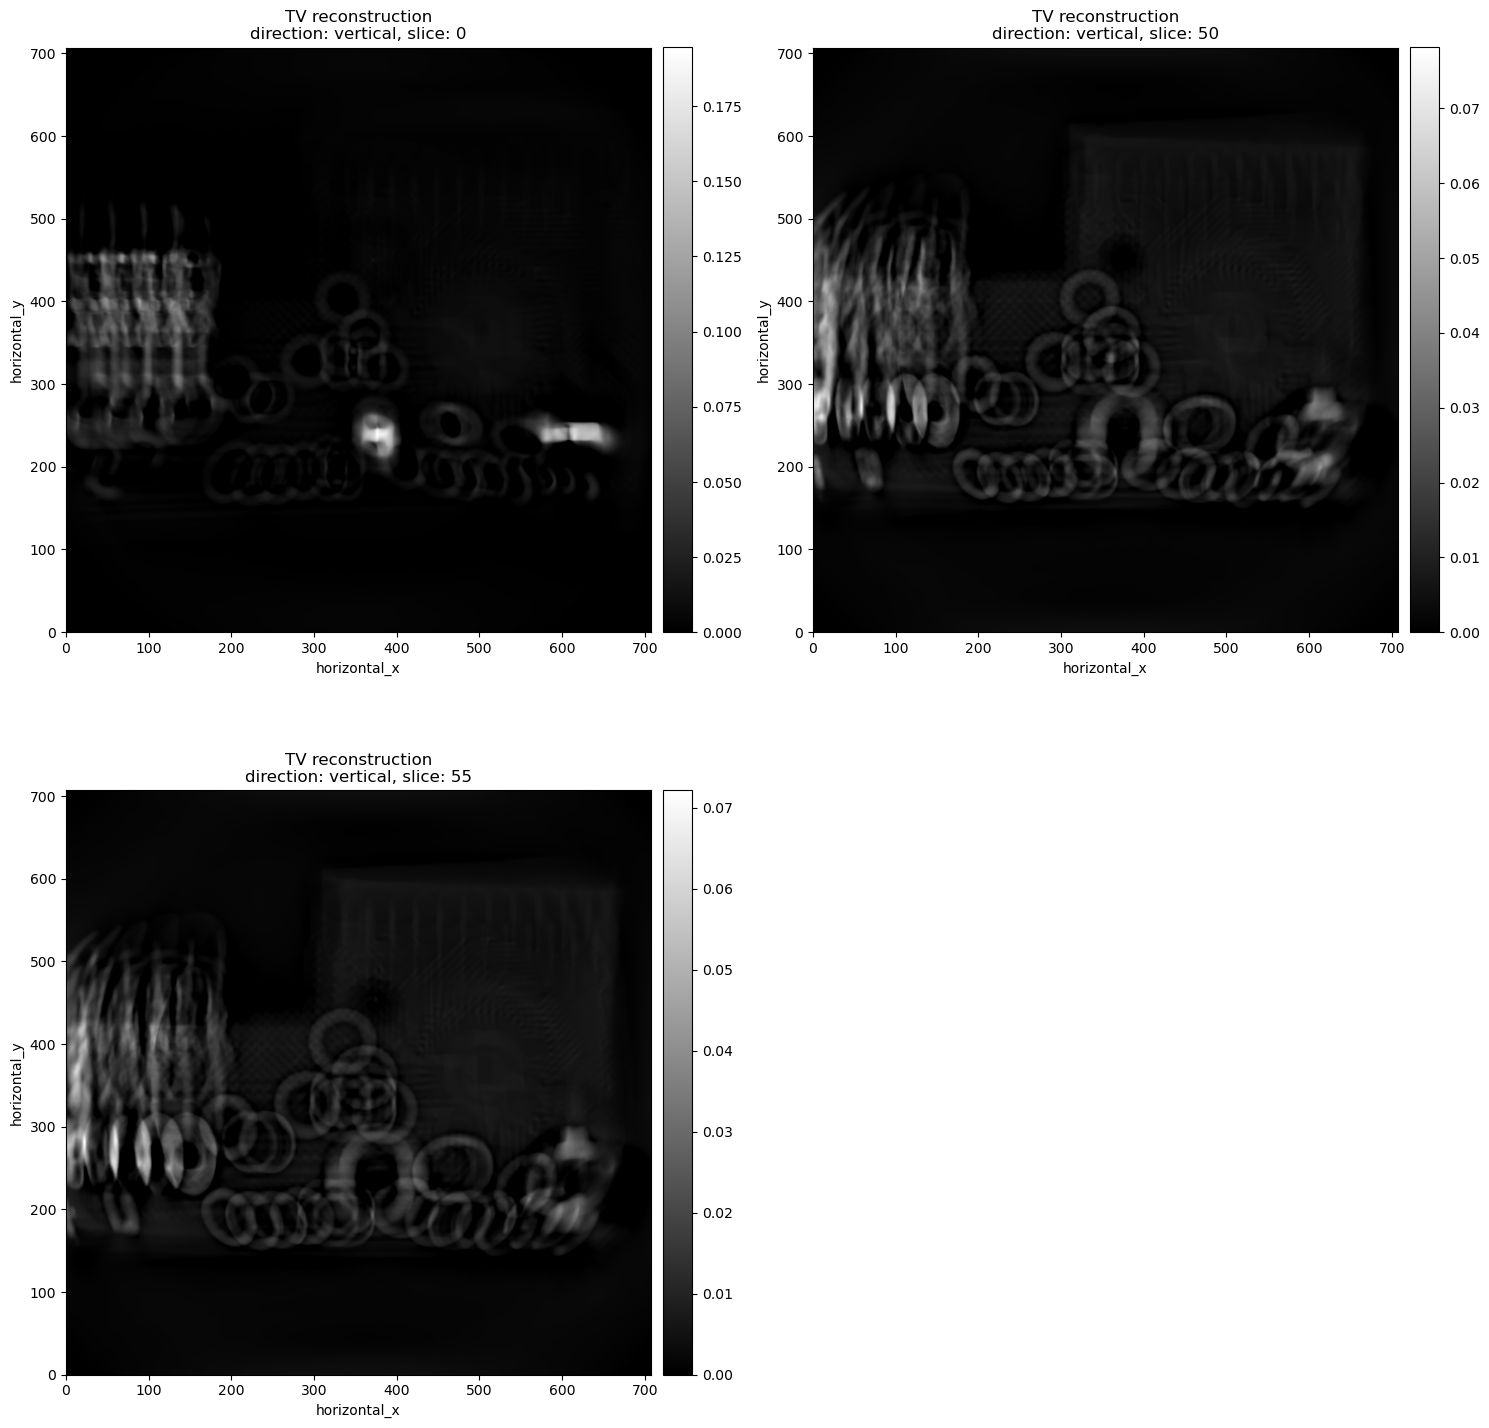

In [30]:
show2D(TV_reco,slice_list=slice_list, title="TV reconstruction")

## Comparing the results

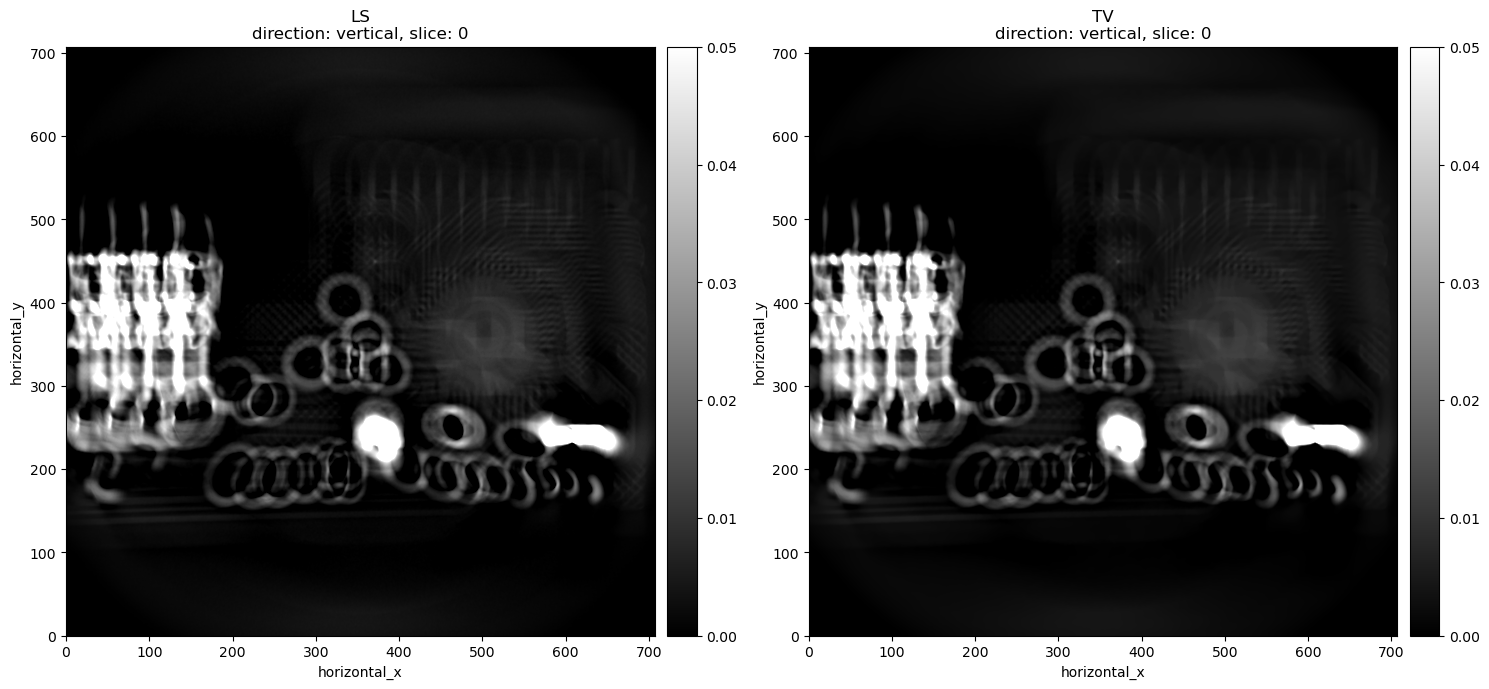

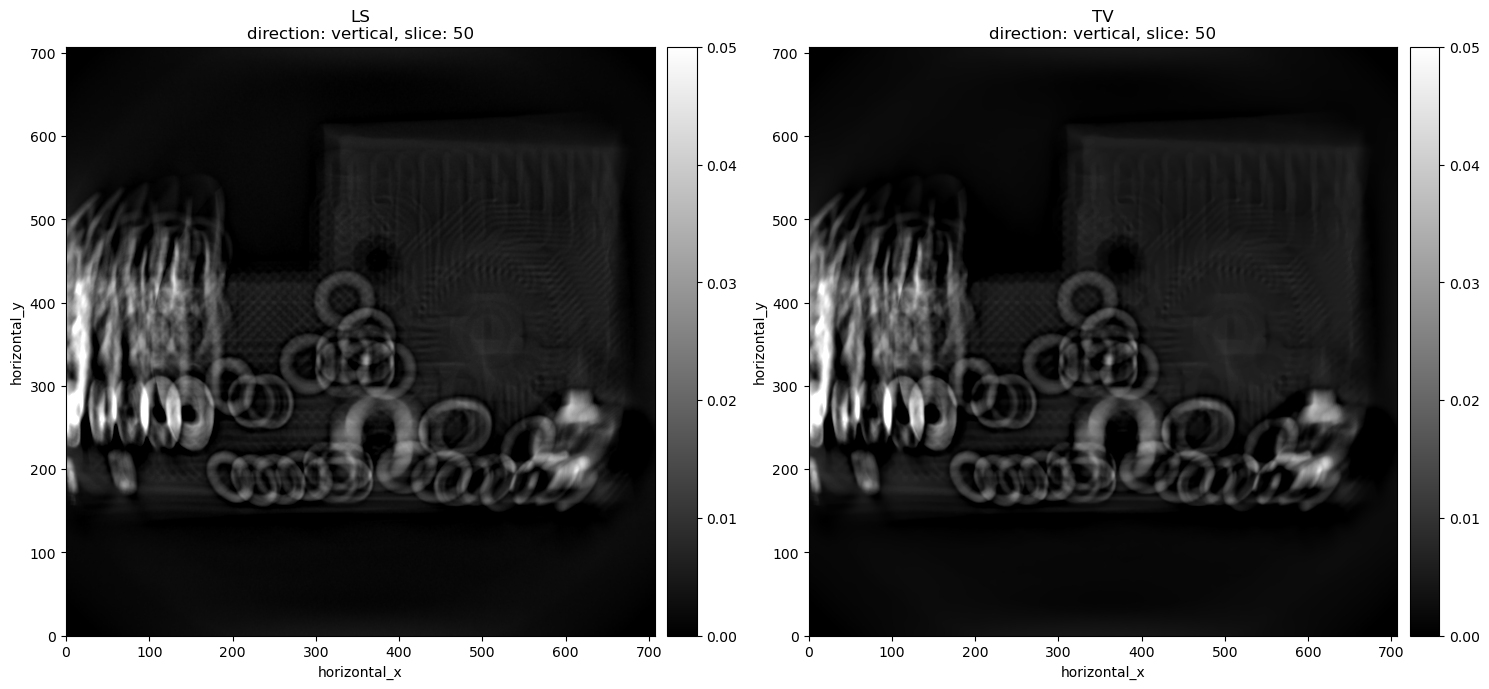

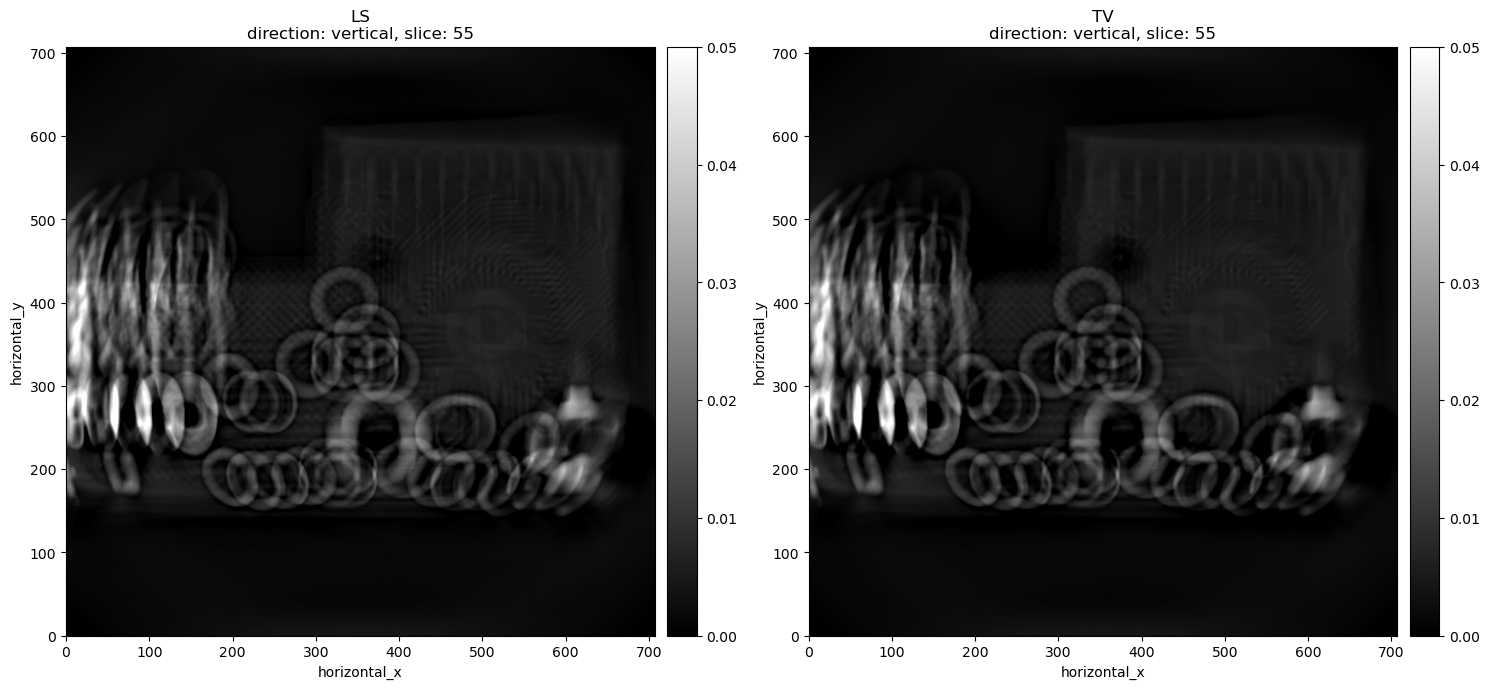

In [31]:
for sl in slice_list:
    show2D([LS_reco,TV_reco],slice_list=sl, title=['LS','TV'], fix_range=(0,0.05),num_cols=2)